# EXPLORATION_13프로젝트 : CIFAR-10 이미지 생성하기

- GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많다.
- 이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 본다.
- 모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있다.

1) 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
2) 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
3) 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

## STEP 0. 작업환경 구성하기

In [6]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples

In [7]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints

In [8]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [57]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import np_utils
print("tensorflow", tf.__version__)

tensorflow 2.4.1


## STEP 1. 데이터셋 구성하기
CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있다.

In [10]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

In [11]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [12]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [14]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화한다.
- 로드한 학습 데이터를 시각화를 통해 확인해 본다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 본다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

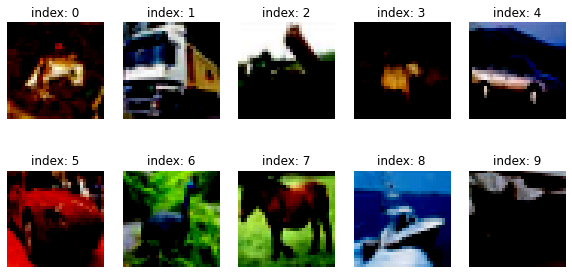

In [15]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

**모든 이미지는 train_images에서 랜덤으로 추출**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

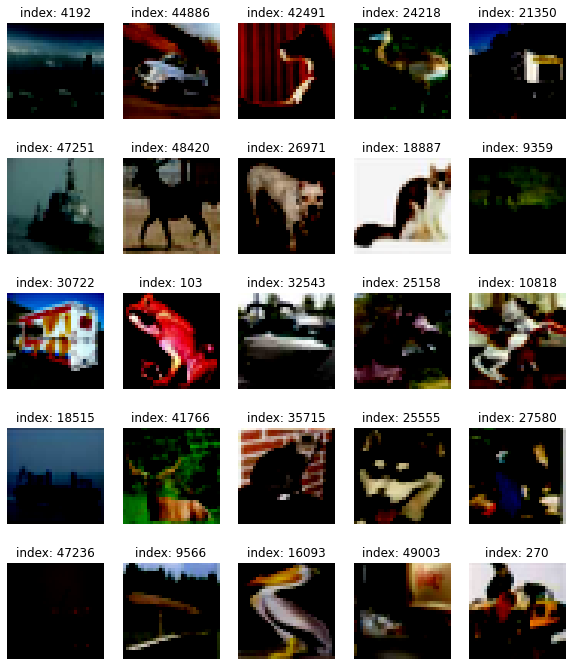

In [17]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

### 1.1Hyperparameter

- BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정한다., BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양이다.

In [18]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 본다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 본다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 본다.

In [21]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [22]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [23]:
noise = tf.random.normal([1, 100])

In [24]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

- 함수 내부에서는 먼저 tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓아준다.
- 여기에서 가장 중요한 레이어는 바로 Conv2DTranspose 레이어이다. Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다.
- 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 256) → (16, 16, 64) → (32, 32, 3) 순으로 이미지를 키워나간다.
-  여기서 최종 사이즈인 (32, 32, 1)은 우리가 준비했던 데이터셋과 형상이 동일하다.

## STEP 3. 판별자 모델 구현하기
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 본다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 본다,

In [26]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [27]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [28]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00028226]], dtype=float32)>

**정리**
- 판별자 또한 make_discriminator_model 함수로 구현하였다.
- Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나간다.
- 첫 번째 Conv2D 층에서 입력된 [32, 32, 1] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 1) → (16, 16, 64) → (8, 8, 128)까지 줄어들게된다.
- 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력합니다.

## STEP 4. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 본다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 본다.
- 생성자와 판별자를 최적화하는 optimizer를 정의한다.

### 4.1 손실함수(loss function)
- GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다.
- 교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이다.
- 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰인다.
- 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것이다.

**생성자와 판별자의 목적이 무엇이었는지 한번 정리해보자**
- 생성자는 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어 한다. 
**- 판별자는 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것이 목표이다.**

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.**
- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

**fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까?**
- 바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 된다.
- 이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용한다

### 4.2 generator_loss
- generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 된다. 
- 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [30]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 4.3 discriminator_loss
- discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산한다.
- real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 된다.

**최종 discriminator_loss 값은 이 둘을 더한 값이다.**

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 4.4 discriminator accuracy
- 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다.
- 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.

In [32]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 4.5 최적화 함수(optimizer)

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- Adam 최적화 기법 을 활용할 것이다.
- Adam 함수 또한 tf.keras.optimizers 안에 있다.
- 중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행 한다.

### 4.6  학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플
100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 한다

In [34]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 5. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 본다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 본다..
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 본다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 본다.

In [36]:
@tf.function
def train_step(images):  #(1) 입력데이터
    #(2) 생성자 입력 노이즈
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) 

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # (3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)
        # (4) generated_images 생성

        # (5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # (6)loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # (7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    # (8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # (9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #(10) 리턴값
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

**train_step 함수를 하나하나 뜯어보면 다음과 같다**
(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴
이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 된다.

### 5.1 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다

In [41]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False) # 결과값이 나오는 부분

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        temp_invcal = predictions.numpy()
        temp_invcal = (temp_invcal * 127.5) + 127.5 # [0, 255]로 스케일링(역산)
        temp_invcal = temp_invcal.astype(int)
        plt.subplot(4, 4, i+1)
        plt.imshow(temp_invcal[i]) # 역산한 값 넣기
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 5.2 매 epoch마다 시각화하는 함수

In [42]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6  

def draw_train_history(history, epoch):
    #summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    #summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    history_save_path = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_history3/'

    try : 
        if not os.path.exists(history_save_path) :      
            #지정한 경로가 없으면 생성하는 코드
            os.makedirs(history_save_path)
    except OSError :
        print('Erroe : Creating directory. ', + history_save_path)
    
    #training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장.
    plt.savefig(history_save_path + 'train_history_{:04d}.png'.format(epoch))
    plt.show()

### 5.3 checkpoint 모델

- 정기적으로 모델을 저장하기 위한 checkpoint를 만들어 준다.
- tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다. 
- 모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적이다.

- checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장한다. 
- 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장하는 것이다. 
- 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둔다.

In [45]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 본다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 본다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출한다.

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것이다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있다
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시이다.

**지금까지 한 단계를 학습하는 train_step, 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습 과정을 시각화하는 draw_train_history(), 그리고 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 이것들을 한 곳에 합치기만 하면 된다.**

In [46]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

**train() 함수를 실행시키면 드디어 모델이 학습해 나가면서 만들어내는 결과물을 실시간으로 확인할 수 있다**

In [47]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 6.1 GAN 학습

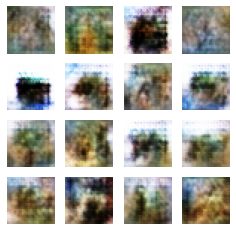

Time for training : 1558 sec


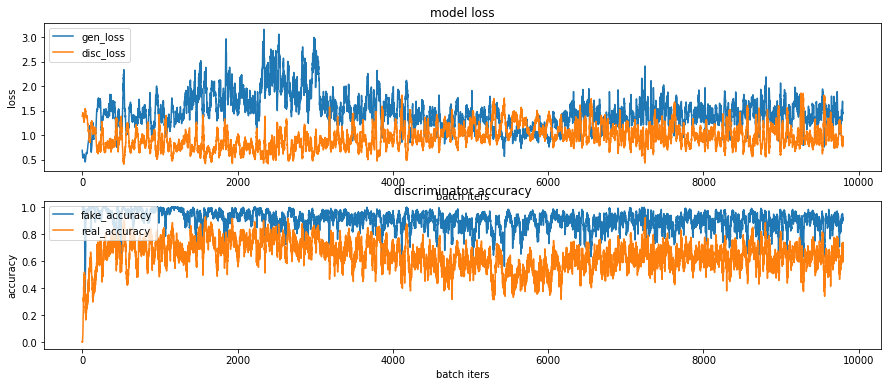

CPU times: user 27min 28s, sys: 1min 2s, total: 28min 30s
Wall time: 25min 59s


In [48]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 6.2 학습과정 시각화하기
- GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 만들 수 있다.
- imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식이다.
- 아래 코드가 무사히 실행되면, fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인할 수 있을 것이다.

In [69]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/cifar10_mnist_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/fashion/cifar10_mnist_dcgan.gif': No such file or directory


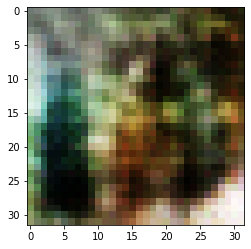

In [73]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

**1차 시도 정리**
- 아직까지는 어떤 이미지인지 알아 보기 어렵다
- real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다.
- fake accuracy가 1.0에 더 가깝다. 가깝다는 것은 판별자를 아직 속이지 못했다는 것이다. 

## STEP 7. (optional) GAN 훈련 과정 개선하기
### 7.1  2차 시도 

In [77]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

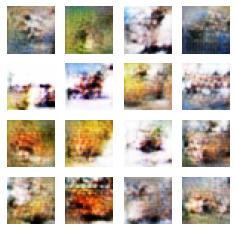

Time for training : 3091 sec


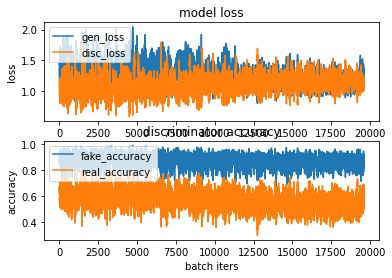

CPU times: user 54min 47s, sys: 1min 53s, total: 56min 41s
Wall time: 51min 32s


In [75]:
%%time
train(train_dataset, EPOCHS, save_every)

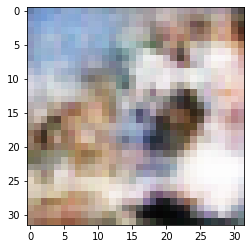

In [76]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

- 1차에 시도한 것 보다 이미지가 조금 뚜렸해졌다
- epochs를 올렸던 것이 조금은 효과가 있었던거 같다. 
- 이미지는 뚜렸해지고 있지만 fake accuracy는 아직 떨어질 기미가 보이지 않는다.


**시도 할 부분**
- epochs를 초대한으로 높여 보기
- 훈련 속도를 높일 수 있는 방법 높이기!
- 3차 시도 하는 너무 오

### 7.1  3차 시도 

In [78]:
save_every = 5
EPOCHS = 150

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

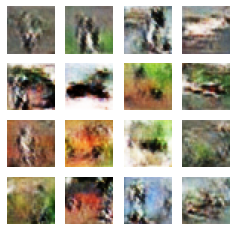

Epoch 108 | iter 51
Time for epoch 108 : 8 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)